In [24]:
import numpy as np
import matplotlib.pyplot as plt

from importations.requirement1 import *

# Pricing Problem

## Best price

In [25]:
T = 100  # Number of days
K = 100  # Discretization for pricing

n_users = 10

cost = 0.1
conversion_probability = lambda p: 1 - p**5
conversion_factor = 1  # Conversion factor to scale down daily payments

Best Price: 0.7171717171717172
Expected Profit at Best Price: 5.000811832754505


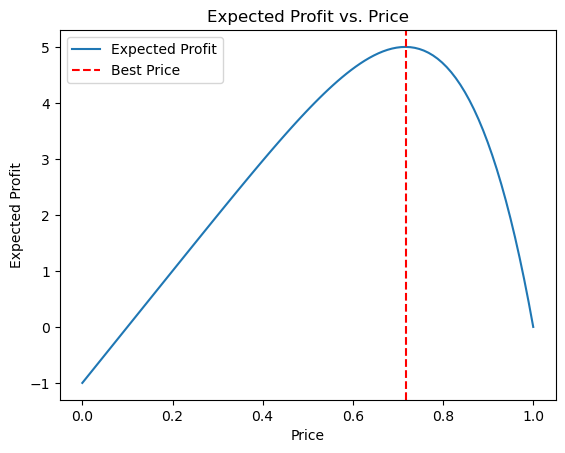

In [26]:
prices = np.linspace(0, 1, K)
reward_function = lambda price, n_sales: (price - cost) * n_sales

# Calculate the expected number of sales for each price
expected_sales = n_users * conversion_probability(prices)

# Calculate the expected profit for each price
expected_profit = reward_function(prices, expected_sales)

# Determine the best price
best_price_index = np.argmax(expected_profit)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(expected_profit[best_price_index], T)

# Print the best price and expected profit
print(f"Best Price: {best_price}")
print(f"Expected Profit at Best Price: {expected_profit[best_price_index]}")

# Plot the expected profit curve
plt.plot(prices, expected_profit, label='Expected Profit')
plt.axvline(best_price, color='red', linestyle='--', label='Best Price')
plt.xlabel('Price')
plt.ylabel('Expected Profit')
plt.title('Expected Profit vs. Price')
plt.legend()
plt.show()

## GPUCB

In [27]:
n_customers = 10 # I assume the number of customers arriving is the same everyday (for now, in general this is not true)

n_trials = 2

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)
    gpucb_agent = GPUCBAgent(T)

    agent_rewards = np.array([])

    for t in range(T):
        p_t = gpucb_agent.pull_arm()
        d_t, r_t = env.round(p_t, n_customers)
        gpucb_agent.update(r_t/n_customers)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards - agent_rewards)
    regret_per_trial.append(cumulative_regret)

    #print(f"Done: {seed}")

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

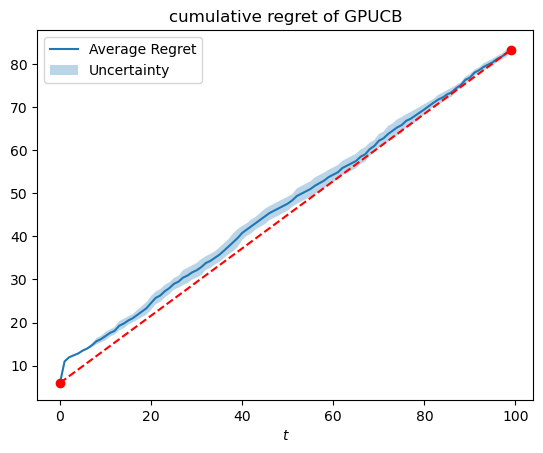

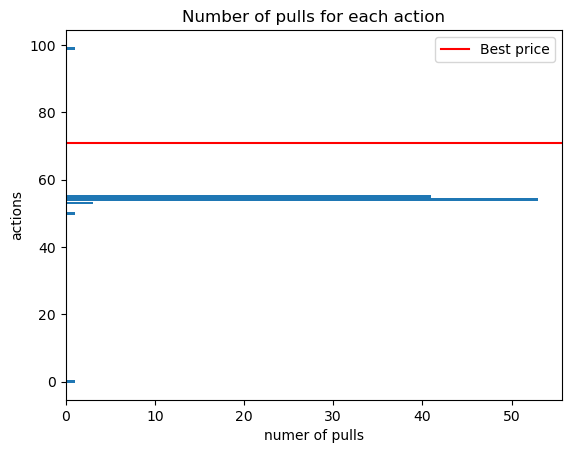

In [28]:
plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of GPUCB')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.figure()
plt.barh(np.arange(100), gpucb_agent.N_pulls)
plt.axhline(best_price_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show();

# Auction Problem

## Clairvoyant bids

In [29]:
def get_clairvoyant_truthful(B, my_valuation, m_t, n_users):
    ## I compute my sequence of utilities at every round
    utility = (my_valuation-m_t)*(my_valuation>=m_t)
    ## Now I have to find the sequence of m_t summing up to budget B and having the maximum sum of utility
    ## In second price auctions, I can find the sequence **greedily**:
    sorted_round_utility = np.flip(np.argsort(utility)) # sorted rounds, from most profitable to less profitable
    clairvoyant_utilities = np.zeros(n_users)
    clairvoyant_bids= np.zeros(n_users)
    clairvoyant_payments = np.zeros(n_users)
    c = 0
    i = 0
    while c <= B-1 and i < n_users:
        clairvoyant_bids[sorted_round_utility[i]] = 1
        clairvoyant_utilities[sorted_round_utility[i]] = utility[sorted_round_utility[i]]
        clairvoyant_payments[sorted_round_utility[i]] = m_t[sorted_round_utility[i]]
        c += m_t[sorted_round_utility[i]]
        i+=1
    return clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments

In [30]:
n_advertisers = 4
n_users = 1000
B = 200

# simple scenario: competitors sample bids from a uniform 
other_bids = np.random.uniform(0, 10*B/n_users, size = (n_advertisers-1, n_users))
# I assume that competitors may have a larger budget than mine (10*B), but they may
# not deplete it.
m_t = other_bids.max(axis=0)

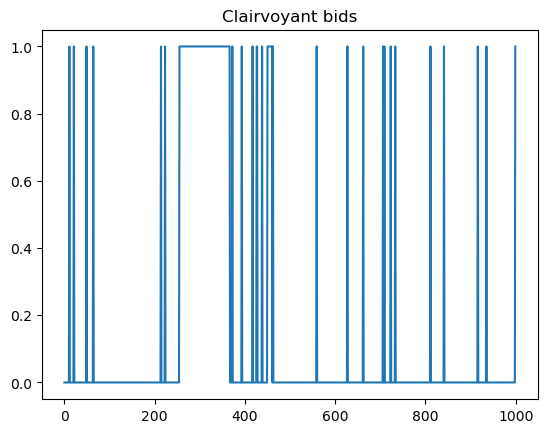

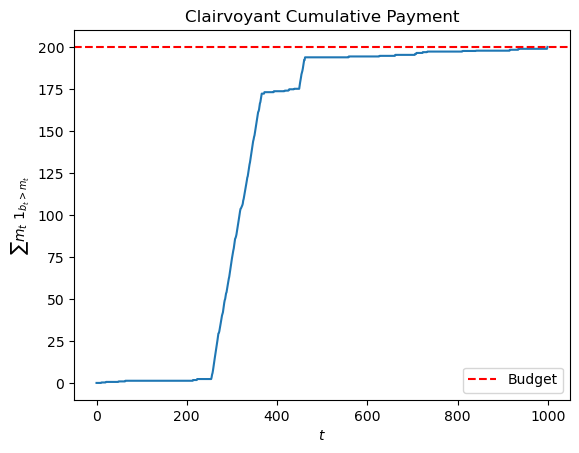

In [31]:
ctr = 1
ctrs = np.ones(n_advertisers)
value_per_click = 0.6
my_valuation = ctr*value_per_click

clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_valuation, m_t, n_users)
plt.title('Clairvoyant bids')
plt.plot(clairvoyant_bids)
plt.show();

plt.title('Clairvoyant Cumulative Payment')
plt.plot(np.cumsum(clairvoyant_payments))
plt.axhline(B, color='red', linestyle='--', label='Budget')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$\sum m_t~ 1_{b_t > m_t}$')
plt.show();

## Multiplicative Pacing algorithm

In [32]:
eta = 1/np.sqrt(n_users) # from theory
agent = MultiplicativePacingAgent(valuation=my_valuation,
                                  budget=B,
                                  T=n_users, 
                                  eta=eta)

auction = SecondPriceAuction(ctrs)

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

np.random.seed(18)
for u in range(n_users):
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(winners==0)
    f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
    agent.update(f_t, c_t)
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win  
print(f'Total # of Wins: {total_wins}')

Total # of Wins: 26


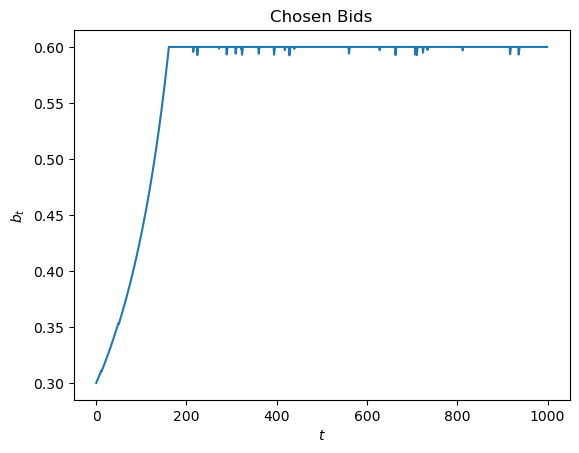

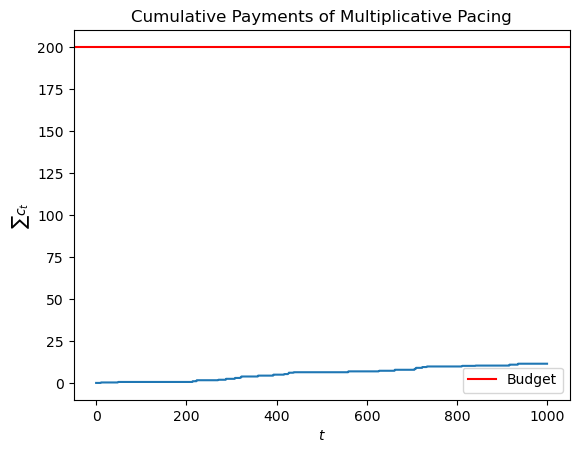

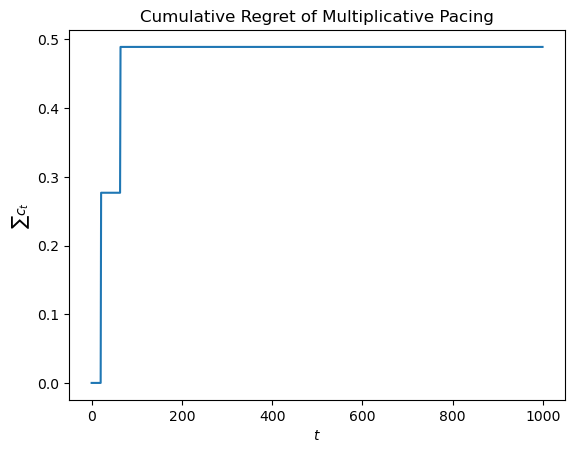

In [33]:
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

cumulative_regret = np.cumsum(clairvoyant_utilities - utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.show()

## UCB-like algorithm

In [34]:
agent = UCBSecondPriceAuctionAgent(valuation=my_valuation, budget=B, T=n_users, K=100, eta=eta)
auction = SecondPriceAuction(ctrs)

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

np.random.seed(18)
for u in range(n_users):
    # interaction
    a_t = agent.pull_arm()
    my_bid = agent.prices[a_t]
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(winners == 0)
    f_t, c_t = (my_valuation - m_t[u]) * my_win, payments_per_click * my_win
    agent.update(a_t, f_t, c_t)  # Pass the actual payment to the update method
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins += my_win

print(f'Total # of Wins: {total_wins}')

Total # of Wins: 30


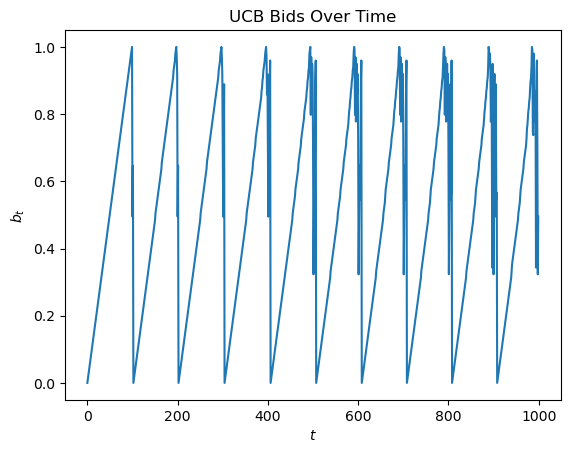

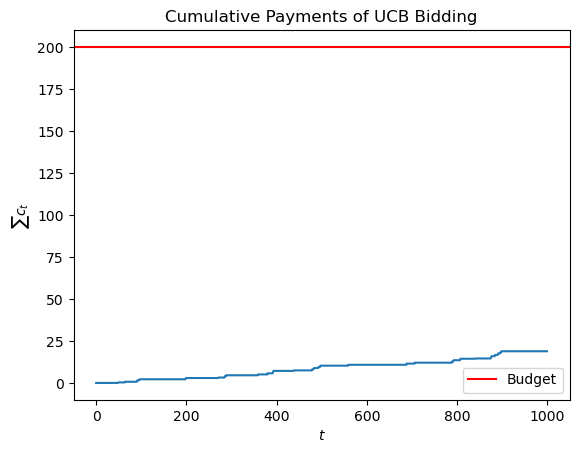

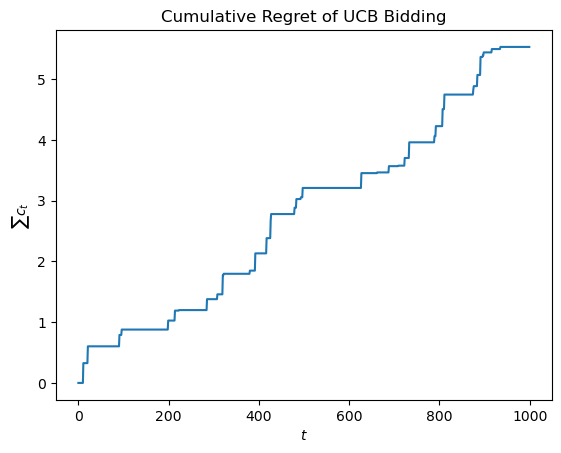

In [35]:
# Results
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('UCB Bids Over Time')
plt.show()

cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of UCB Bidding')
plt.show()

cumulative_regret = np.cumsum(clairvoyant_utilities - utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.title('Cumulative Regret of UCB Bidding')
plt.show()

In [36]:
agent.N_pulls

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 11., 10., 11., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 11., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 11., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10.,  9., 10., 10., 10., 10., 10.,
        9., 10., 10.,  9., 10.,  9., 10., 10., 10.])

# Combining Pricing and Auction

## Parameters

In [37]:
T = 100  # Number of days
K = 100  # Discretization for pricing
n_users = 1000  # Number of users per day

cost = 0.1
conversion_probability = lambda p: 1 - p**5
conversion_factor = 1  # Conversion factor to scale down daily payments

## Initialize the environment

In [38]:
np.random.seed(0)  # Set a single seed
env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)

n_advertisers = 4
B = 200
ctr = 1
ctrs = np.ones(n_advertisers)

eta = 1 / np.sqrt(n_users)

# Instantiate the auction environment
auction = SecondPriceAuction(ctrs)

## Multiplicative Pacing Agent

### Logging variables

In [39]:
# Logging variables
agent_rewards = np.array([])
utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

gpucb_agent = GPUCBAgent(T)

### Run the simulation

In [40]:
## Run the simulation
for day in range(T):
    # Pricing
    p_t = gpucb_agent.pull_arm()
    value_per_click = p_t * conversion_probability(p_t)  # Valuation depends on the price and conversion probability
    my_valuation = ctr * value_per_click

    # Reinitialize the bidding agent for each day
    bidding_agent = MultiplicativePacingAgent(valuation=my_valuation, budget=B, T=n_users, eta=eta)

    other_bids = np.random.uniform(0, 10 * B / n_users, size=(n_advertisers - 1, n_users))
    #other_bids = np.random.uniform(0, 1, size=(n_advertisers - 1, n_users))
    m_t = other_bids.max(axis=0)

    # Run auctions for the day
    daily_wins = 0
    daily_payments = 0
    for user in range(n_users):
        # Bidding
        my_bid = bidding_agent.bid()
        bids = np.append(my_bid, other_bids[:, user].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(winners == 0)
        f_t, c_t = (my_valuation - m_t[user]) * my_win, m_t[user] * my_win
        bidding_agent.update(f_t, c_t)

        # Logging
        utilities = np.append(utilities, f_t)
        my_bids = np.append(my_bids, my_bid)
        my_payments = np.append(my_payments, c_t)
        daily_wins += my_win
        daily_payments += c_t

    # Convert daily payments to a more realistic level
    daily_payments /= conversion_factor

    # Number of customers depends on the number of wins
    n_customers = daily_wins
    d_t, r_t = env.round(p_t, n_customers)
    total_reward = r_t - daily_payments  # Subtract the money spent on auctions
    gpucb_agent.update(total_reward)
    agent_rewards = np.append(agent_rewards, total_reward)
    total_wins += daily_wins

    print(day, total_reward)

# Calculate cumulative regret
cumulative_regret = np.cumsum(agent_rewards)

0 -0.0
1 0.0
2 0.8861823230301455
3 0.37467736336633717
4 0.3298839304628629
5 0.20729014722905337
6 1.6979247888033697
7 0.46526630487850085
8 0.5982183660317091
9 1.2004357355695152
10 1.5048047245035843
11 2.0603829979862613
12 1.6164077733757019
13 1.7605763439918407
14 3.6938498368644943
15 2.184617711267652
16 -2.8623149296929267
17 0.9128940452062846
18 0.4953303690953863
19 -0.5588627806290862
20 3.8023997822447377
21 2.445041767819278
22 1.5754123929502164
23 0.7734615836896932
24 1.168359364204294
25 1.3473215054898233
26 0.37423029351129244
27 1.7085207018686468
28 -0.20168250676048416
29 3.303414797744109
30 3.1849980635850255
31 2.8824559846362625
32 2.1004333018629886
33 0.7912307508787215
34 2.142636294306227
35 0.3556803182826327
36 1.7843338656357641
37 0.35539729006885956
38 1.302810469368696
39 0.16387342112101244
40 0.18909932779244443
41 1.4167909214426615
42 0.8224534127308445
43 2.768398789394377
44 0.9610119112333315
45 2.5471066317932873
46 0.8672057865347043
4

### Plot the results

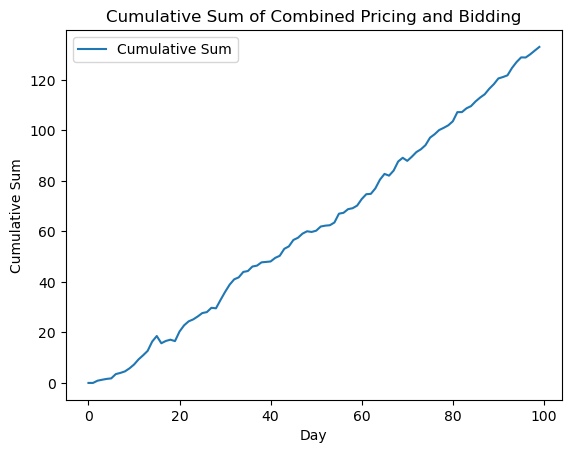

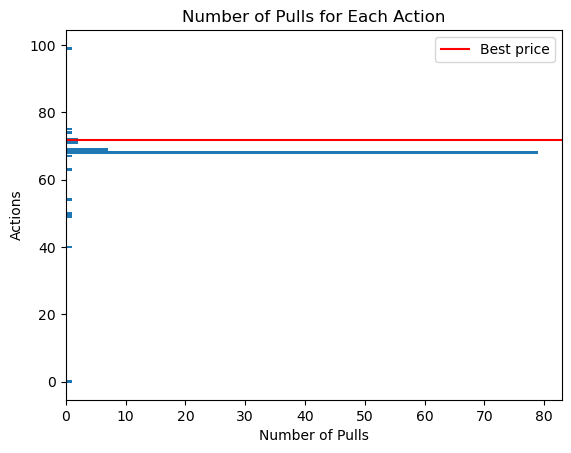

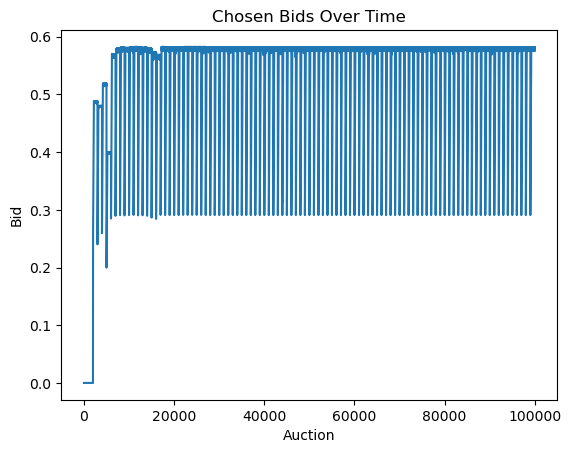

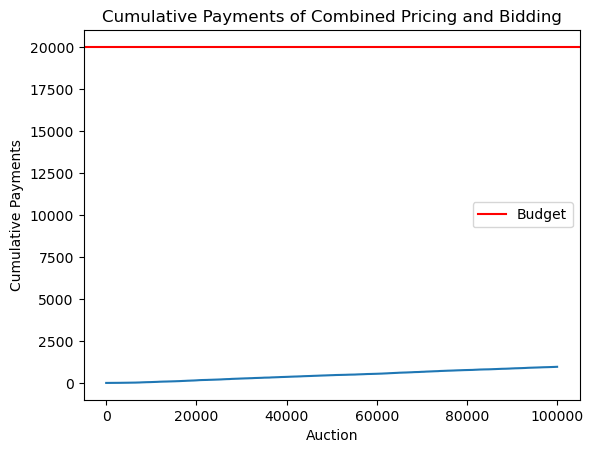

In [41]:
# Plotting results
plt.plot(np.arange(T), cumulative_regret, label='Cumulative Sum')
plt.title('Cumulative Sum of Combined Pricing and Bidding')
plt.xlabel('Day')
plt.ylabel('Cumulative Sum')
plt.legend()
plt.show()

plt.figure()
plt.barh(np.arange(100), gpucb_agent.N_pulls)
plt.axhline(best_price*100, color='red', label='Best price')
plt.ylabel('Actions')
plt.xlabel('Number of Pulls')
plt.legend()
plt.title('Number of Pulls for Each Action')
plt.show()

plt.plot(my_bids)
plt.xlabel('Auction')
plt.ylabel('Bid')
plt.title('Chosen Bids Over Time')
plt.show()

cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('Auction')
plt.ylabel('Cumulative Payments')
plt.axhline(B*T, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Combined Pricing and Bidding')
plt.show()

In [42]:
gpucb_agent.N_pulls

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  0.,  1., 79.,  7.,  0.,  2.,  2.,  0.,  1.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.])

## UCB Agent

### Logging variables

In [43]:
# Logging variables
agent_rewards = np.array([])
utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

gpucb_agent = GPUCBAgent(T)

### Run the simulation

In [44]:
## Run the simulation
for day in range(T):
    # Pricing
    p_t = gpucb_agent.pull_arm()
    value_per_click = p_t * conversion_probability(p_t)  # Valuation depends on the price and conversion probability
    my_valuation = ctr * value_per_click

    # Reinitialize the bidding agent for each day
    bidding_agent = UCBSecondPriceAuctionAgent(valuation=my_valuation, budget=B, T=n_users, K=K, eta=eta)

    other_bids = np.random.uniform(0, 10 * B / n_users, size=(n_advertisers - 1, n_users))
    #other_bids = np.random.uniform(0, 1, size=(n_advertisers - 1, n_users))
    m_t = other_bids.max(axis=0)

    # Run auctions for the day
    daily_wins = 0
    daily_payments = 0
    for user in range(n_users):
        # Bidding
        a_t = bidding_agent.pull_arm()
        my_bid = bidding_agent.prices[a_t]
        bids = np.append(my_bid, other_bids[:, user].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(winners == 0)
        f_t, c_t = (my_valuation - m_t[user]) * my_win, m_t[user] * my_win
        bidding_agent.update(a_t, f_t, c_t)

        # Logging
        utilities = np.append(utilities, f_t)
        my_bids = np.append(my_bids, my_bid)
        my_payments = np.append(my_payments, c_t)
        daily_wins += my_win
        daily_payments += c_t

    # Convert daily payments to a more realistic level
    daily_payments /= conversion_factor

    # Number of customers depends on the number of wins
    n_customers = daily_wins
    d_t, r_t = env.round(p_t, n_customers)
    total_reward = r_t - daily_payments  # Subtract the money spent on auctions
    gpucb_agent.update(total_reward)
    agent_rewards = np.append(agent_rewards, total_reward)
    total_wins += daily_wins

    print(day, total_reward)

# Calculate cumulative regret
cumulative_regret = np.cumsum(agent_rewards)


0 -17.934374771724233
1 -18.715948648843
2 -19.379300986940596
3 -17.398433837487392
4 -15.575858022880674
5 -23.243761956280192
6 -16.536144825597866
7 -23.438026848293628
8 -18.527591331751207
9 -18.139412439517866
10 -26.724284111489034
11 -15.069586142038071
12 -21.738598094483184
13 -18.294770681896267
14 -28.16314939803229
15 -12.832381072745715
16 -13.418275639073569
17 -20.531577768650845
18 -22.66279035365733
19 -18.589195760896924
20 -23.00393113289197
21 -14.60134629824477
22 -16.10651195768546
23 -19.048959505528504
24 -20.621771393818214
25 -17.028741189278474
26 -19.578588426839584
27 -23.42654849285868
28 -12.243663005914907
29 -19.000671199315324
30 -16.22894704068587
31 -16.969332604193294
32 -14.510416666967318
33 -14.238031558624535
34 -17.62320530952103
35 -16.391615589899775
36 -21.327635777839724
37 -14.618325613919806
38 -19.769987945731014
39 -20.000523222911585
40 -22.975305773119814
41 -22.706843755567288
42 -15.830505082655494
43 -18.629296953183175
44 -16.02

### Plot the results

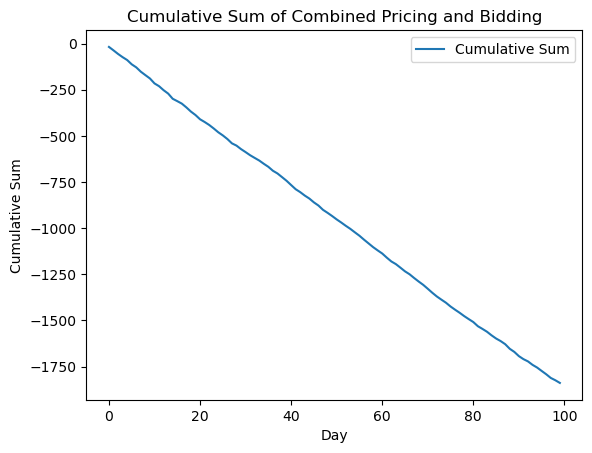

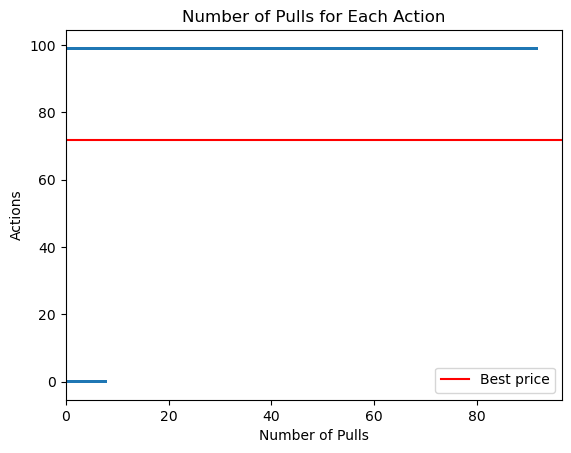

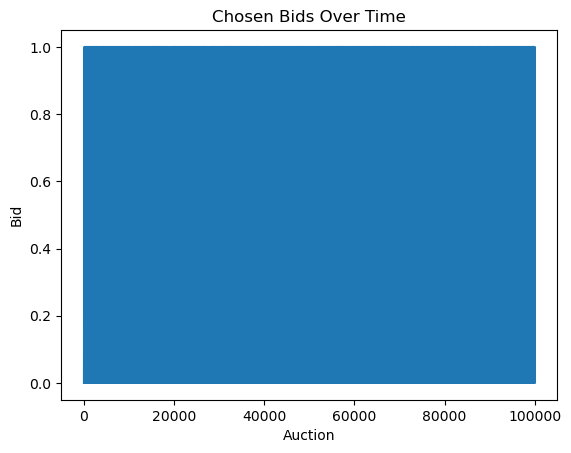

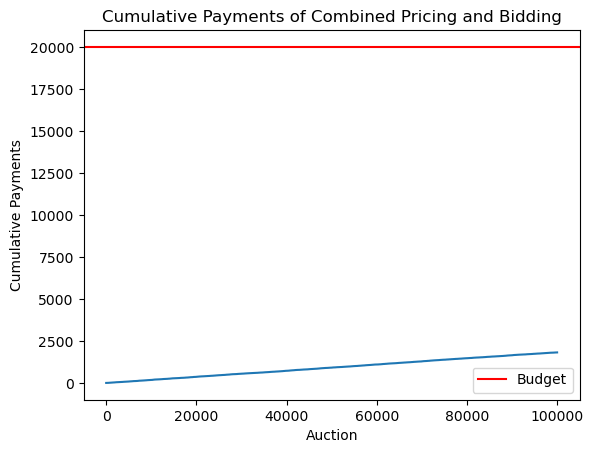

In [45]:
# Plotting results
plt.plot(np.arange(T), cumulative_regret, label='Cumulative Sum')
plt.title('Cumulative Sum of Combined Pricing and Bidding')
plt.xlabel('Day')
plt.ylabel('Cumulative Sum')
plt.legend()
plt.show()

plt.figure()
plt.barh(np.arange(100), gpucb_agent.N_pulls)
plt.axhline(best_price*100, color='red', label='Best price')
plt.ylabel('Actions')
plt.xlabel('Number of Pulls')
plt.legend()
plt.title('Number of Pulls for Each Action')
plt.show()

plt.plot(my_bids)
plt.xlabel('Auction')
plt.ylabel('Bid')
plt.title('Chosen Bids Over Time')
plt.show()

cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('Auction')
plt.ylabel('Cumulative Payments')
plt.axhline(B*T, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Combined Pricing and Bidding')
plt.show()

In [46]:
gpucb_agent.N_pulls

array([ 8.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 92.])